In [ ]:
!pip install --global-option=--noopenmp dtaidistance

In [2]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from Parser import parse_frames
from scipy.signal import medfilt
from Functions import analyse_each_rep, find_extremas, filter_extremas, numpy_fillna, DTWDistance
from JointAngles import JointAngles
import numpy as np
import glob
import os
import pickle
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


# Skip this part

In [7]:
# input_folder = "C:\\Users\\altaok\\Documents\\GitHub\\IndividualProject\\keypoints_for_all\\shoulder press"
input_folder = 'C:\\Users\\ak5u16\\Desktop\\IndividualProject\\keypoints_for_all\\shoulder_press'
folder_paths = glob.glob(os.path.join(input_folder, 'shoulder_press*'))
points_folder_name = os.path.basename(input_folder)

print(len(folder_paths))


def get_data_for_dataset(folder_paths, points_folder_name):
    angle_arrays = []
    for folder in folder_paths:
        video_name = os.path.basename(folder)
        label = 0 if '_correct' in folder else 1
        frame_poses = parse_frames(folder)
        joint_angles = JointAngles(points_folder_name, frame_poses)
        
        left_upArm_forearm_angles = np.array(joint_angles.left_upArm_forearm_angles)
        left_upArm_forearm_angles = np.nan_to_num(left_upArm_forearm_angles)
        left_upArm_forearm_angles_filtered = medfilt(medfilt(left_upArm_forearm_angles, 5), 5)
            
        right_upArm_forearm_angles = np.array(joint_angles.right_upArm_forearm_angles)
        right_upArm_forearm_angles = np.nan_to_num(right_upArm_forearm_angles)
        right_upArm_forearm_angles_filtered = medfilt(medfilt(right_upArm_forearm_angles, 5), 5)
            
        left_upArm_trunk_angles = np.array(joint_angles.left_upArm_trunk_angles)
        left_upArm_trunk_angles = np.nan_to_num(left_upArm_trunk_angles)
        left_upArm_trunk_angles_filtered = medfilt(medfilt(left_upArm_trunk_angles, 5), 5)
            
        right_upArm_trunk_angles = np.array(joint_angles.right_upArm_trunk_angles)
        right_upArm_trunk_angles = np.nan_to_num(right_upArm_trunk_angles)
        right_upArm_trunk_angles_filtered = medfilt(medfilt(right_upArm_trunk_angles, 5), 5)
            
        extremas1 = filter_extremas(left_upArm_trunk_angles_filtered, find_extremas(left_upArm_trunk_angles_filtered, maxima=False), maxima=False)
        extremas2 = filter_extremas(right_upArm_trunk_angles_filtered, find_extremas(right_upArm_trunk_angles_filtered, maxima=False), maxima=False)
            
        angle_arrays.append((label, extremas1, extremas2, [left_upArm_forearm_angles, right_upArm_forearm_angles, left_upArm_trunk_angles, right_upArm_trunk_angles]))


    return angle_arrays
                                             
                                    

def fill_dataframe(angle_arrays, exercise_folder_name):
    df_list = []
    
    print('Filling dataset with ' + str(exercise_folder_name) + ' data...')
    count = (0,0)
   
    for tup in angle_arrays:
        label = tup[0]
        extremas1 = tup[1]
        extremas2 = tup[2]
        uf_angles1, uf_angles2, ut_angles1, ut_angles2 = tup[3]
        # Extract rep angles
        each_rep_angles, tup = analyse_each_rep('shoulder_press', 'dataset', extremas1=extremas1, uf_angles1=uf_angles1, ut_angles1=ut_angles1, extremas2=extremas2, uf_angles2=uf_angles2, ut_angles2=ut_angles2)
        count = (count[0] + tup[0], count[1] + tup[1]) 
        
        #print(len(each_rep_angles))
        s1 = pd.Series(each_rep_angles, name='Angle_array')
        s2 = pd.Series([label for n in range(len(each_rep_angles))], name='Label')
        df = pd.concat([s1,s2], axis=1)
        df_list.append(df)

    return pd.concat(df_list).reset_index(drop=True), count
        

56


In [9]:
angle_arrays = get_data_for_dataset(folder_paths, points_folder_name) 
df, count = fill_dataframe(angle_arrays, points_folder_name)
print(df.info())

Filling dataset with shoulder_press data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 2 columns):
Angle_array    1688 non-null object
Label          1688 non-null int64
dtypes: int64(1), object(1)
memory usage: 26.5+ KB
None


# Import dataset using pickle and perform clustering


In [3]:
from sklearn.preprocessing import normalize
df = pickle.load( open( "datasets/shoulder_press_df.pickle", "rb" ) )

#df['Angle_array'] = df['Angle_array'].apply(lambda x: x / np.linalg.norm(x))



 

In [94]:
df.tail()

,Angle_array,Label
1683,"[0.12103272746981561, 0.1210505472681445, 0.12...",1
1684,"[0.12843393353494395, 0.12911819695472443, 0.1...",1
1685,"[0.12789677594087517, 0.13208306170781517, 0.1...",1
1686,"[0.12690270570458803, 0.1268985513474579, 0.12...",1
1687,"[0.13052651387525194, 0.13054011448106123, 0.1...",1


In [51]:
a = [1,2,3,4]
print(a[-2:])

[3, 4]


Cluster correct repetitions to create Ground Truth Model

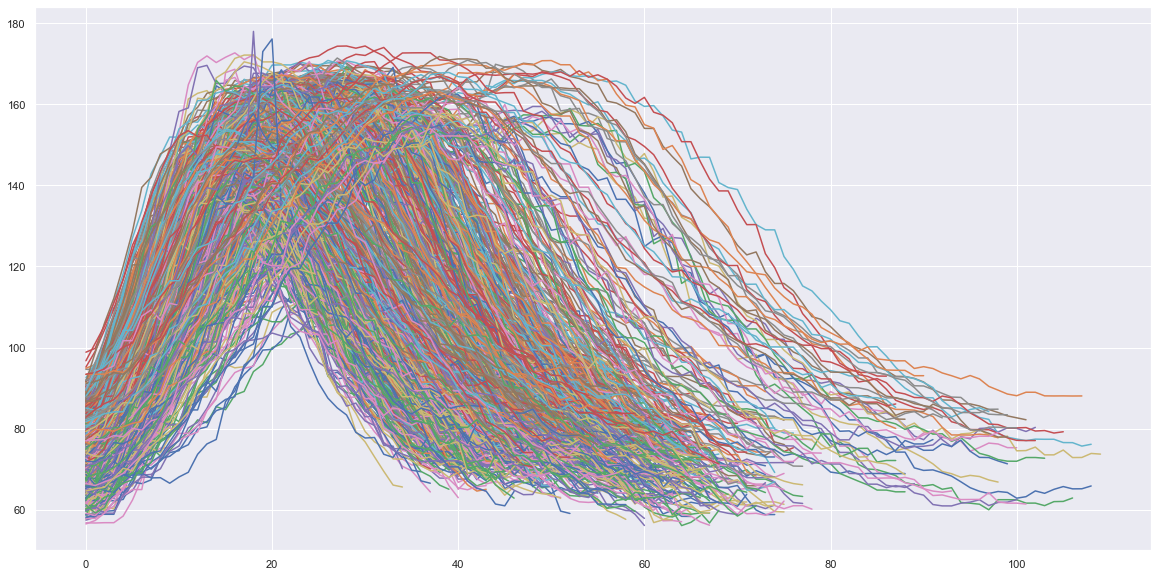

In [5]:
from dtaidistance import dtw, clustering
import seaborn as sns;sns.set()
new_df = df[df['Label'] == 0]
series = new_df.Angle_array.values.tolist()
#print(series)

#model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
#cluster_idx = model1.fit(series)
# Augment Hierarchical object to keep track of the full tree
#model2 = clustering.HierarchicalTree(model1)
#cluster_idx = model2.fit(series)
# SciPy linkage clustering
#model = clustering.LinkageTree(dtw.distance_matrix_fast, {}, method='single')
#cluster_idx = model.fit(series)

timeseries = pd.DataFrame()
ax = None
plt.figure(figsize=(20, 10))
for ts in series:
    df_ts = pd.DataFrame(ts)
    #print(df_ts.head())
    #print(df_ts.values)
    timeseries = timeseries.append(df_ts)
    #print('ye')
    ax = sns.lineplot(ax=ax,data=ts)

plt.show()
   


In [9]:
print(len(timeseries))

52000


In [144]:
timeseries.head()

,0
0,0.073836
1,0.079775
2,0.082717
3,0.090004
4,0.097043


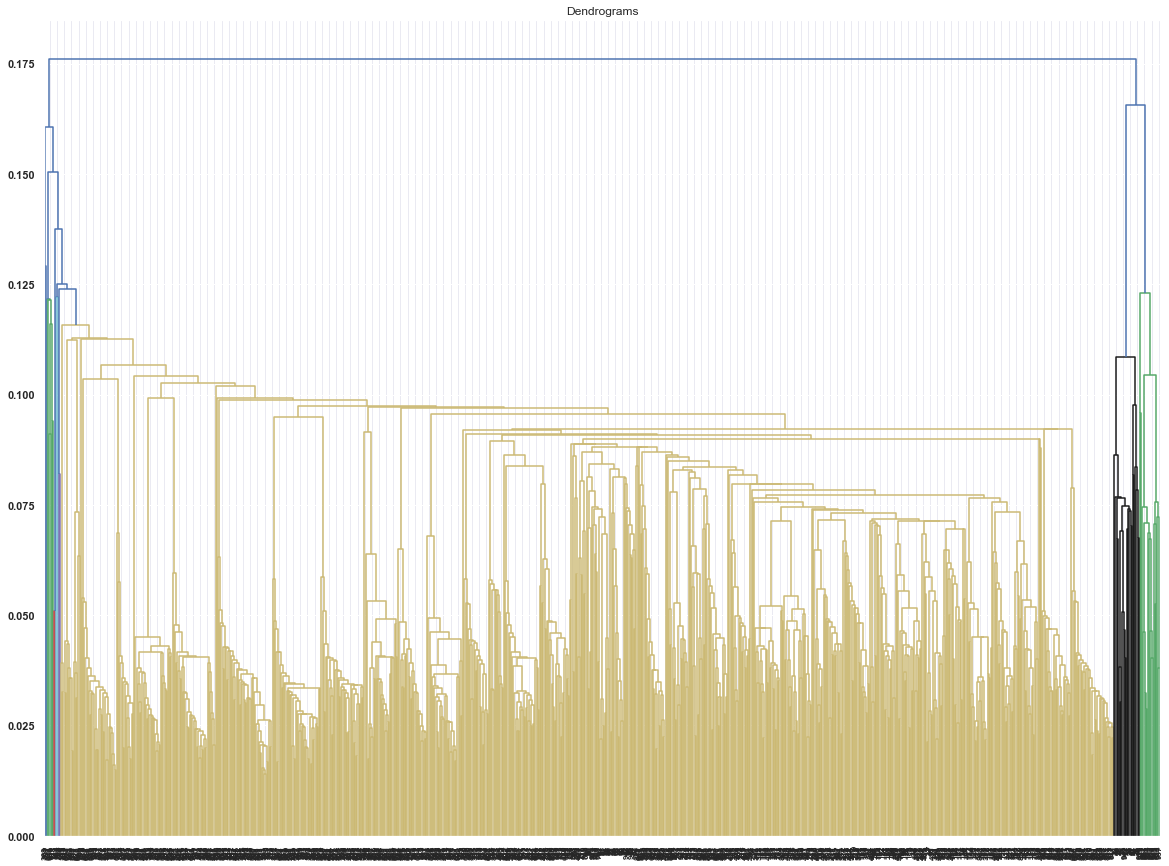

In [39]:
import scipy.cluster.hierarchy as shc

font = {'weight' : 'bold',
        'size'   : 40}

plt.rc('font', **font)
plt.figure(figsize=(20, 15))  

plt.title("Dendrograms")  
Z = shc.linkage(numpy_fillna(new_df['Angle_array'].values), method='single')
dend = shc.dendrogram(Z, leaf_font_size=8.)

In [90]:
from sklearn.cluster import AgglomerativeClustering
ds = dtw.distance_matrix_fast(series)
ds[ds == np.inf] = 0
cluster = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='complete')  
pred = cluster.fit_predict(ds)

In [234]:
import sys

np.set_printoptions(threshold=sys.maxsize)

In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 959
Data columns (total 2 columns):
Angle_array    960 non-null object
Label          960 non-null int64
dtypes: int64(1), object(1)
memory usage: 22.5+ KB


In [31]:
cluster1 = pred[pred == 0]
cluster2 = pred[pred == 1]
cluster3 = pred[pred == 2]
cluster4 = pred[pred == 3]
#cluster5 = pred[pred == 4]
print('cluster 1 size', cluster1.size)
print('cluster 2 size', cluster2.size)
print('cluster 3 size', cluster3.size)
print('cluster 4 size', cluster4.size)
#print('cluster 5 size', cluster5.size)

NameError: name 'pred' is not defined

110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110


In [26]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset


km = TimeSeriesKMeans(n_clusters=2, metric="dtw",max_iter=5,  random_state=0).fit(to_time_series_dataset(new_df['Angle_array'].values))


In [30]:
km.cluster_centers_.shape

(2, 34, 1)

In [28]:
pred2 = km.labels_
#print(pred2)
cluster1 = pred2[pred2 == 0]
cluster2 = pred2[pred2 == 1]
cluster3 = pred2[pred2 == 2]
#cluster4 = pred2[pred2 == 3]
#cluster5 = pred[pred == 4]
print('cluster 1 size', cluster1.size)
print('cluster 2 size', cluster2.size)
print('cluster 3 size', cluster3.size)
#print('cluster 4 size', cluster4.size)
#print('cluster 5 size', cluster5.size)

cluster 1 size 740
cluster 2 size 220
cluster 3 size 0


In [82]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(ts, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    print(clusters)

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            ts.Angle_array.T.iloc[:,cluster_indeces].plot()
            plt.show()

print_clusters(new_df, Z, 2, plot=False)

[1 2]
Cluster 1 number of entries 920
Cluster 2 number of entries 40


In [79]:
count

(844, 844)

In [226]:
from dtaidistance import dtw, clustering

model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {}, method='ward')
model3.fit(new_df.Angle_array.values.tolist())

In [227]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
#show_ts_label = lambda idx: "ts-" + str(idx)
model3.plot("hierarchy.png", axes=ax, 
           ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)

(None, None)

In [47]:
model.plot("myplot.png")

(None, None)

In [46]:
print(cluster_idx)

None


# Classification

In [21]:
from sklearn.model_selection import train_test_split
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

y = df['Label']
x = df['Angle_array']
#x = numpy_fillna(x)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
X_train.shape

(1350,)

In [27]:
X_test.shape

(338,)

In [30]:
k_range = range(1, 26) #26
scores = {}
scores_list = []
for k in k_range:
    knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    #knn_clf = KNeighborsClassifier(k, n_jobs=-1)
    knn_clf.fit(numpy_fillna(X_train.values), y_train)
    #knn_clf.fit(X_train, y_train)
    predicted_labels = knn_clf.predict(numpy_fillna(X_test.values))
    acc = metrics.accuracy_score(y_test, predicted_labels)
    scores[k] = acc
    #print("Correct classification rate:", acc)
    #print('\n')
    #print(metrics.classification_report(y_test, predicted_labels))
    #print('F1 score: ' + str(metrics.f1_score(y_test, predicted_labels, average='macro')))


for key, value in scores.items():   
    if value == max(scores.values()):
        print('best value for k: ' + str(key) + ' - ' + str(value))
        break

best value for k: 3 - 0.9497041420118343


In [24]:
with open('datasets/shoulder_press_df.pickle', 'wb') as f:
    pickle.dump(df, f)